# <center>  Python for biologists

---

# Lecture 12. Statistics (and some extra things)

30.11.2024


Скорее всего вы будете работать с чем-то из

- [SciPy](https://scipy.org/)
- [statsmodels](https://www.statsmodels.org/stable/)
- [pingouin](https://pingouin-stats.org/build/html/index.html)
- [scikit-learn](https://scikit-learn.org/stable/index.html)

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from scipy import stats

In [4]:
data_dir = 'https://raw.githubusercontent.com/Python-BI-2024-25/course_materials/main/data/'
titanic = pd.read_csv(data_dir + 'titanic.csv')

In [23]:
titanic.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_normalized
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,2.178064
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2.079442
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,2.369075


## Some basic tests with `pingouin` package

In [7]:
pg.corr(titanic.Fare , titanic.Age)

,n,r,CI95%,p-val,BF10,power
pearson,331,0.337932,"[0.24, 0.43]",2.763372e-10,2.811e+07,0.999995


In [8]:
pg.normality(titanic.Fare, alpha=.05)

,W,pval,normal
Fare,0.539302,1.377187e-31,False


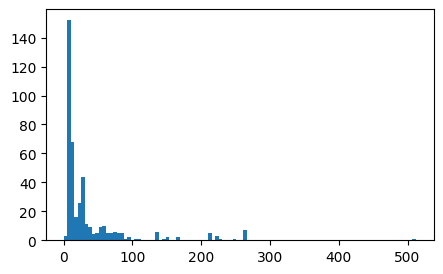

In [14]:
plt.figure(figsize=(5, 3))
plt.hist(titanic.Fare, bins=100);

In [15]:
titanic['Fare_normalized'] = np.log(titanic.Fare + 1) 

In [17]:
pg.normality(titanic['Fare_normalized'], alpha=.05)

,W,pval,normal
Fare_normalized,0.888213,7.390268e-17,False


In [21]:
pg.ttest(titanic.Fare_normalized, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,63.626413,416,two-sided,1.720137e-216,"[2.92, 3.11]",3.115799,2.121e+212,1.0


In [22]:
x = titanic.query('Sex == "male"')['Fare']
y = titanic.query('Sex == "female"')['Fare']
pg.ttest(x, y)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.447868,206.764522,two-sided,0.000685,"[-34.93, -9.51]",0.404447,32.646,0.977563


## Regression models with `statsmodels`

### Fitting regression model

In [24]:
titanic = titanic.dropna()
model = smf.ols("Fare ~ Sex + Age + Pclass + Parch", titanic)
results = model.fit()

In [25]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Fare   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     7.094
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           5.90e-05
Time:                        18:25:00   Log-Likelihood:                -499.72
No. Observations:                  87   AIC:                             1009.
Df Residuals:                      82   BIC:                             1022.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     140.8781     41.764      3.373      

In [26]:
model = smf.ols("Fare ~ Sex + Age + Pclass + Parch + 0", titanic)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Fare   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     7.094
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           5.90e-05
Time:                        18:25:06   Log-Likelihood:                -499.72
No. Observations:                  87   AIC:                             1009.
Df Residuals:                      82   BIC:                             1022.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Sex[female]   140.8781     41.764      3.373      

In [27]:
results.params

Sex[female]    140.878100
Sex[male]      124.453548
Age              0.263019
Pclass         -55.955156
Parch           38.734385
dtype: float64

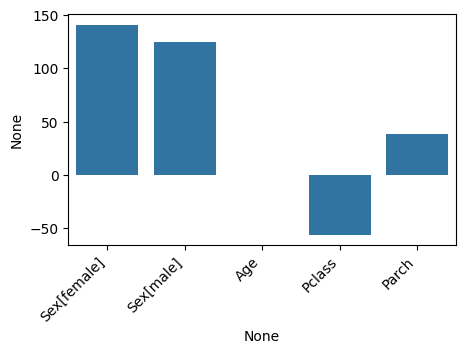

In [30]:
plt.figure(figsize=(5, 3))
sns.barplot(x=results.params.index, y=results.params)
plt.xticks(rotation=45, ha='right');

### Using model for predictions

In [31]:
model = smf.ols("Fare ~ Sex + Age + Pclass + Parch", titanic).fit()

In [46]:
pred = model.get_prediction(titanic).predicted

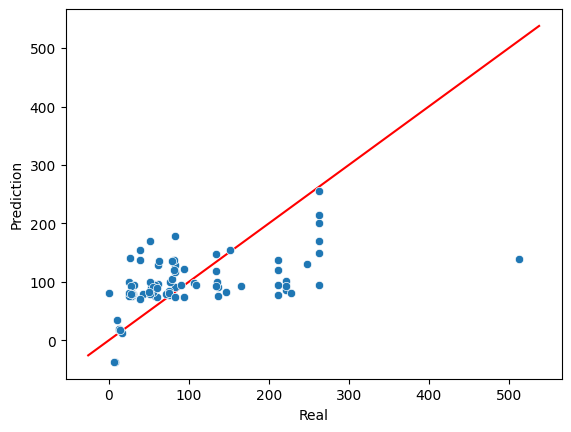

In [47]:
sns.scatterplot(y = pred, x = titanic.Fare);

plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), 
         zorder=-1, color='red')
plt.xlabel("Real")
plt.ylabel("Prediction");

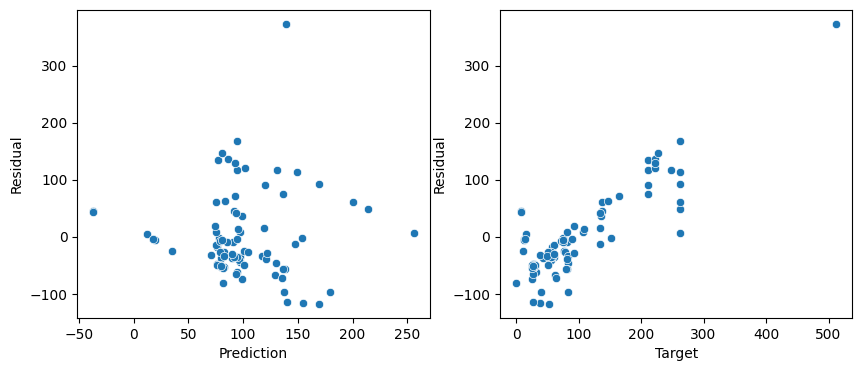

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
resid = titanic.Fare - pred
sns.scatterplot(x=pred, y=resid, ax=ax1)
ax1.set_xlabel("Prediction");
ax1.set_ylabel("Residual");

sns.scatterplot(x=titanic.Fare, y=resid, ax=ax2, )
ax2.set_xlabel("Target");
ax2.set_ylabel("Residual");

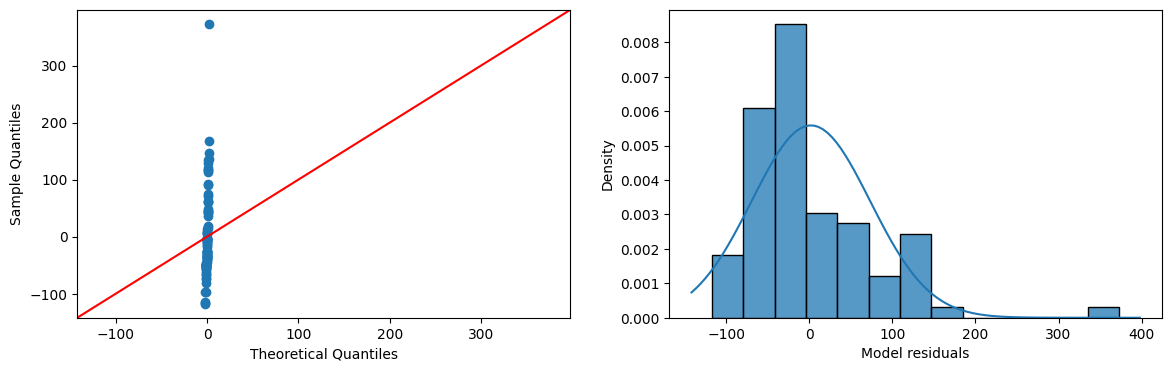

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

sm.qqplot(resid, line='45', ax=ax1);

ax2 = sns.histplot(resid, stat='density');
x = np.random.normal(resid.mean(), resid.std(), size=1000)
mu, std = stats.norm.fit(x)
xx = np.linspace(*ax2.get_xlim(), num=100)
ax2.plot(xx, stats.norm.pdf(xx, mu, std));
ax2.set_xlabel('Model residuals');

# Additional Python things: good to know

- $\lambda$-функции
- *f*-строки
- Исключения

## $\lambda$-функции

Это попросту альтернативный механизм создания функций. Выглядит это так:

```python
lambda x, y: print(x + y)
```

Оно состоит из 3-х частей:

- Ключевое слово `lambda` - объявляет создание $\lambda$-функции
- Перечесление ожидаемых аргументов
- Тело функции
  
При этом как видете во всем этом деле никак не фигурирует имя функции. В теории $\lambda$-функции можно присвоить имя:

```python
f = lambda x, y: print(x + y)
```

Интересно, что здесь немного стираются границы между функциями и переменными. В python есть просто объекты и ссылки на них (имена). При этом имена вообще не знают о том, являются ли объекты под ними callable или нет.

Именования $\lambda$-функции соотвествует записи:

```python
def f(x, y):
    print(x, y)
```

Однако, **не надо именовать $\lambda$-функции**. $\lambda$-функции еще принято называть "анонимными", подчеркивая что им не принято давать имена.

### Зачем нужны $\lambda$-функции? ###
Чтобы быстро и немногословно определить и сразу же использовать функцию именно там где нужно.

### Пример $\lambda$-1. Работа с дата-фреймами
1. Можно лакончино что-нибудь переименовать
2. Можно лаконично что-то сделать с данными

In [69]:
df = pd.DataFrame({'col1_start': [1, 2, 3],
                   'col2_end': [5, 6, 7],
                   'col3_value': [0, 0, 2]
                  })

df

,col1_start,col2_end,col3_value
0,1,5,0
1,2,6,0
2,3,7,2


In [70]:
df.apply(lambda x: x / x.sum(), axis=0) # нормировка 

,col1_start,col2_end,col3_value
0,0.166667,0.277778,0.0
1,0.333333,0.333333,0.0
2,0.500000,0.388889,1.0


In [71]:
df.rename(lambda x: x.split('_')[1], axis=1) # переименование колонок

,start,end,value
0,1,5,0
1,2,6,0
2,3,7,2


### Пример $\lambda$-2. Соленый язык без проблем с регистром

In [72]:
import re

def salt(text):
    vowels = r'([ауоиэыяюеёАУОИЭЫЯЮЕЁ])'
    return re.sub(vowels, 
                  lambda x: x.group(0) + 'c' + x.group(0).lower(), 
                  text) 


In [73]:
salt('Ура!') # дубликат буквы "У" в нижнем регистре

'Уcураcа!'

### Где испольовать $\lambda$-функции, а где обычные?
- Если код функции не влезает в 1 строчку - вам нужна обычная
- Если функция используется более 1 раза - вам нужна обычная
- Если вам нужно дать функции имя - вам нужна обычная
- Если вам нужно применить небольшую функцию к набору данных - вам нужна $\lambda$-функция
- Если вы не уверены, вам нужна обычная функция

## *F*-строки

F - от слова *format*. Они нужны, когда мы хотим каким либо образом модифицировать (форматировать) строки в нашем коде.

Например, я получаю имя человека и хочу с ним поздороваться. Это можно сделать и через сложение строк:

In [52]:
greeting = 'Hello, my name is '
name = 'nikita'
greeting + name

'Hello, my name is nikita'

Но то же самое можно сделать с помощью форматирования строк. Для этого в начале строки ставится символ f и нужные нам объекты передаются внутри `{` фигурных `}` скобок.

In [53]:
f'Hello, my name is {name}'

'Hello, my name is nikita'

### Несколько фактов про f-строки.
  
- **F-строки удобно использовать во всяких таких историях шаблон + конкретный объект.**

In [55]:
names = ('nikita', 'sasha', 'lena')
for name in names:
    print(f"Hello, my name is {name}!")

Hello, my name is nikita!
Hello, my name is sasha!
Hello, my name is lena!


- **Внутри фигурных скобок можно делать какие-то операции.** <br/>
  Например, было бы логично сделать имя с заглавной буквы

In [56]:
f"Hello, my name is {name.capitalize()}!"

'Hello, my name is Lena!'

Можно математические операции делать

In [58]:
my_num = 2
f"Your number is {my_num + 1}"

'Your number is 3'

Но будьте аккуратнее! Какую-то одну штучку сделать ок. Если же вы там какую-то обработку будете делать, это уже будет плохо читаться. Сперва делайте обработку, потом подставляйте в шаблон, чтобы не было все вперемешку.

- **Внутри фигурных скобок можно информативно отобразить переменную:**

In [59]:
age = 22
print(f' My {age}')
print(f' My {age = }') 

 My 22
 My age = 22


- **Внутри фигурных скобок форматировать числа с помощью `:`:**

In [60]:
pi = 3.141592653589793846
print(f"Pi is {pi}!")
print(f"Pi is {pi:.2f}!") # float-point, 2 знака после запятой
print(f"Pi is {pi:.3e}!") # exponential, 3 знака после запятой

Pi is 3.141592653589794!
Pi is 3.14!
Pi is 3.142e+00!


In [61]:
print(f"Pi is {pi = :.2f}!") # кстати можно комбинировать:)

Pi is pi = 3.14!


- **Текст внутри можно дополнительно оформлять для печати:** <br/>Мы тут:

    - Ставим : чтобы задать правила оформления
    - Ставим число чтобы задать ширину блока в символах (штуках)
    - Между : и числом можно поставить любой символ из < ^ > чтобы выровнять текст (влево, по-центру и вправо). По-умолчанию выравнивание вправо.
    - Между : и символом выравнивания можно добавить символ, которых будет заполнять пустоту

In [62]:
pi = 3
print(f"Pi is {pi}!")
print(f"Pi is {pi:10}! (ширина 10, вправо (дефолт))")
print(f"Pi is {pi:<10}! (ширина 10, влево)")
print(f"Pi is {pi:^10}! (ширина 10, по-центру)")
print(f"Pi is {pi:>10}! (ширина 10, вправо)")
print(f"Pi is {pi:-^10}! (ширина 10, по-центру, заполнили пустоту)")
print(f"Pi is {pi:=^10}! (ширина 10, по-центру, заполнили пустоту)")

Pi is 3!
Pi is          3! (ширина 10, вправо (дефолт))
Pi is 3         ! (ширина 10, влево)
Pi is     3     ! (ширина 10, по-центру)
Pi is          3! (ширина 10, вправо)
Pi is ----3-----! (ширина 10, по-центру, заполнили пустоту)
Pi is ====3=====! (ширина 10, по-центру, заполнили пустоту)


- **Можно форматировать не только текст и числа, но и целые даты!:**

Здесь используются символы через `%`. Посмотреть значение каждого можно в [табличке тут](https://docs.python.org/3/library/datetime.html#datetime.timezone). Между ними можно писать что угодно

In [63]:
import datetime
today = datetime.datetime.today()
print(f"{today:%Y-%m-%d}") # год месяц день
print(f"{today:Year %Y, month %m, day %d}") # год месяц день
print(f"{today:%H:%M (%I:%M%p)}") # часы:минуты (часы:минуты в 12-часовом формате)

2024-11-29
Year 2024, month 11, day 29
18:44 (06:44PM)


- **Можно делать f-строки вложенными, если менять типы кавычек:**

In [64]:
x = 'F-string'
print(f'''-{f"""*{f"+{f'.{x}.'}+"}*"""}-''')

-*+.F-string.+*-


### Применения f-строк в биоинформатике
Тут чисто примеры, самих применений немеренное множество

1) Писать сообщение пользователю <br/>
Например, если он ввел вам неправильную операцию

In [65]:
operation = 'multiply'
operations = ['add', 'divide']

if operation not in operations:
    print( f"Unknown operation {operation}!")

Unknown operation multiply!


2) Простейшее логгирование - уведомлять какой образец был обработан

In [67]:
# Набор образцов
samples = [
    'A1', 'A2', 
    'B1', 'B2'
]

# Функция которую нам нужно с ними сделать (очень полезная, но долгая)
def some_doings(data):
    for i in range(1, 10000):
        nothing = 0
    return data

# перебираем образцы
for sample in samples:
    print(f'{sample:-^32}') # взяли образец
    print('Start doings') # оповестили что начали работу
    sample = some_doings(sample)
    print(f'Sample {sample} succesefully processed\n') # оповестили о завершении

---------------A1---------------
Start doings
Sample A1 succesefully processed

---------------A2---------------
Start doings
Sample A2 succesefully processed

---------------B1---------------
Start doings
Sample B1 succesefully processed

---------------B2---------------
Start doings
Sample B2 succesefully processed



3) Читать и записывать файлы с сложными названиями, формировать названия образцов и т.п.

In [68]:
import os

# Набор образцов
samples = [
    'A1', 'A2', 
    'B1', 'B2'
]

def read_file(path):
    return 666

# перебираем образцы
for sample in samples:
    filename = f'ChIPSeq_{sample}_filtered.fastq.gz'
    path = os.path.join('data', filename)
    print(f'Reading file `{path}`' )

Reading file `data/ChIPSeq_A1_filtered.fastq.gz`
Reading file `data/ChIPSeq_A2_filtered.fastq.gz`
Reading file `data/ChIPSeq_B1_filtered.fastq.gz`
Reading file `data/ChIPSeq_B2_filtered.fastq.gz`


Тут понятно можно выдумывать что-то совсем жуткое))

```python
for qval in (0.01, 0.05):
    for res in (50000, 100000):
        for bl in (0.01, 0.1, 0.5):
            filename = f"HiC_{res//1000}kb_bl{bl}_merged_all_q{qval}.pkl"
            path = os.path.join('data', filename)
            df = pd.read_pickle(path)
```

## Исключения

В Python существуют исключения, хотя мы их обычно называем ошибками.

In [74]:
1 / 0

ZeroDivisionError: division by zero

In [75]:
my_dict = {0: 1, 1: 0}

my_dict[2]

KeyError: 2

Исключения можно не только созерцать в слезах но и **обрабатывать**. Давайте вспомним хорошо вам известную констирукцию `if-else`:

```python
if <condition>:
    something()
elif <other condition>:
    other_something()
else: 
    somtehing_else()
```

По аналогии можно легко понять конструкцию для обработки исключений: `try-except`

```python
try:
    something_dangerous()
except (ValueError, ArithmeticError):
    something()
except TypeError as e:
    something_else(e)
except:
    another_one_something()
```

- Можно просто обработать ситуацию возникновения исключения, а можно что-то сделать с самим исключением. Для этого его нужно перехватить с помощью `as e`. Имя `e` может быть любым, но в таком варианте является конвенцией
- Исключение `e` обрабатывается веткой `except`, если её первый аргумент expr можно сопоставить с исключением: `isinstance(e, expr)`
- При наличии нескольких веток `except` интерпретатор сверху вниз ищет подходящую.
- Переменная `e` существует только внутри блока `except`


In [77]:
try:
    print('Trying 1/0')
    1/0
except ZeroDivisionError as e:
    print('e:', e)

print('Exited')
print(e)

Trying 1/0
e: division by zero
Exited


NameError: name 'e' is not defined

Если еще некоторые ключевые слова:
- `finally` - выполнится после `try-except` в любом случае
- `else` - выполнится после `try-except` если ошибки не случилось

In [78]:
var  = 0
try:
    var = 1/var
except ZeroDivisionError as e:
    print('e:', e)
else:
    var = var/1
finally:
    print(var)

e: division by zero
0


In [79]:
var  = 1
try:
    var = 1/var
except ArithmeticError as e:
    print('e:', e)
else:
    var = var/1
finally:
    print(var)

1.0


Эти блоки (`else` и `finally`) используются не так часто, но иногда они полезны. **Ключевое правило при работе с `try-except`** - делать это только там где нужно. ***Не пишите весь код внутри try-except***. Используйте его на конкретных строчках где возможна ошибка. Ну и помните, что возможно по логике вам нужен не try-except, а предварительное условие с проверкой данных. А может вам не нужно ни того ни другого. ***Ловить исключения не всегда хорошо!*** Если программа упала с ошибкой - это здорово, мы этого ожидаем. Вот если ошибка есть, а программа не упала - вот это очень плохо. Поэтому если что-то в вашем коде падает - скорее всего лучше просто оставить как есть чтобы оно падало. Самый частый кейс ловли исключений - для сохранения инфы в файл с логами. Ловить исключения просто чтобы их не было не правильно!

### Дерево наследований исключений

Давайте представим такую ситуацию. Вы решили посчитать с помощью `numpy` $\sqrt{-1}$. Каков будет результат?

In [82]:
np.sqrt(-1)

/tmp/ipykernel_144/3438155168.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-1)


np.float64(nan)

Будет `np.nan`... Что-ж. Давайте воспользуемся специальным контекстным менеджером numpy который сделает код сильно более требовательным к правильности операций:

In [83]:
with np.errstate(invalid='raise'):
    np.sqrt(-1)

FloatingPointError: invalid value encountered in sqrt

Вот мы получили ошибку `FloatingPointError`. Супер! А теперь представьте что вы в вашей программе хотите поймать абсолютно любую арифметическую ошибку: деление на 0, корень из -1 и всё что угодно еще.

Предусмотреть все возможные варианты? 

На самом деле - можно отловить родительское исключение - `ArithmeticError`. Да, у исключений ей четкая иерархия наследования. Если вы ловите какое-то исключение, то это значит что вы поймаете и любое из его наследников. Но не родителей, логично.


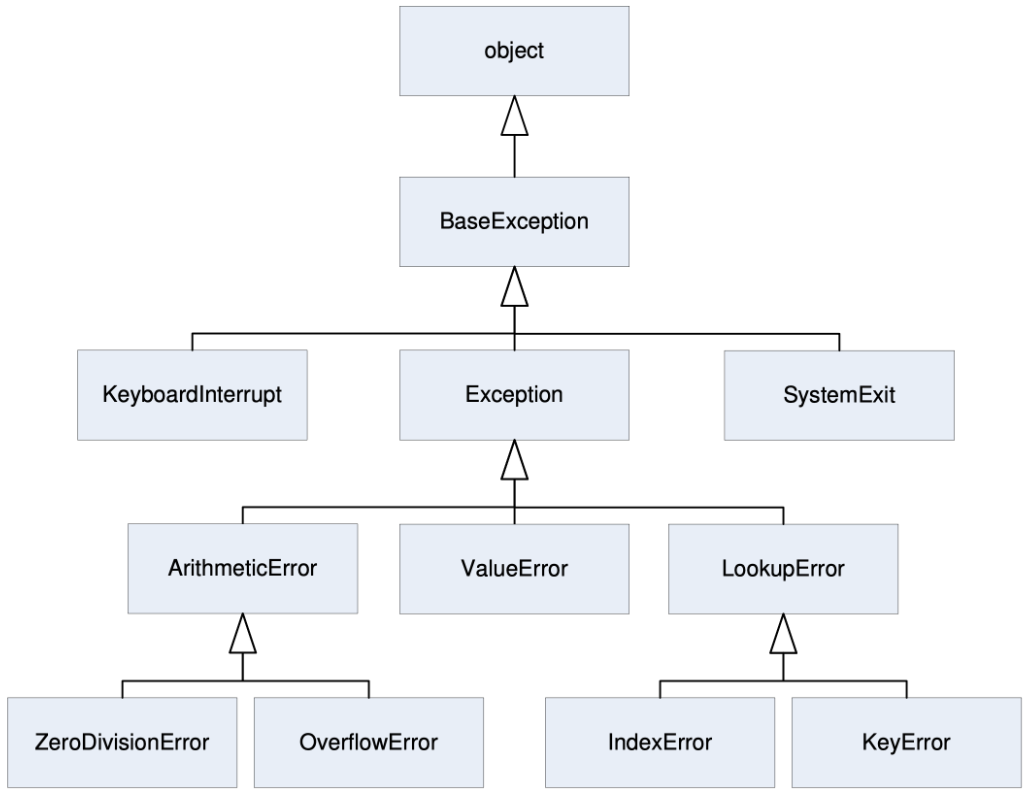

Вообще не принято уходить слишком "наверх". Лучше ловить конкретные исключения. В саааамом худшем случае можно ловить `Exception`. ***НИКОГДА*** не ловитие ничего выше него. Попытка написать:

```python
try:
    ...
except BaseException:
    ...
```

Приведет к тому что вы, например, словите в том числе и прерывание с клавиатуры. То есть вы не сможете остановить свою программу по `Ctrl + C`. И даже `SystemExit` её не остановит.

--- 

Тем не менее, а как вообще устроено это дерево наследований, как устроены исключения, и как устроены вообще любые объекты в питоне - это мы начнем узнать на первой лекции следующего семестра. А пока что - перерыв.


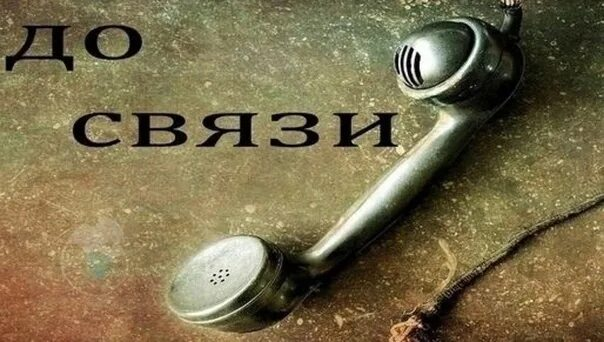